# Introduction 

Dans ce tp, vous apprendrez les bases du Q-Learning en créant et en entraînant votre propre agent de tic-tac-toe.

L'apprentissage par renforcement (RL) est un domaine de l'apprentissage automatique qui s'intéresse à la manière dont les agents intelligents devraient entreprendre des actions dans un environnement afin de maximiser la notion de récompense cumulative. L'apprentissage par renforcement est l'un des trois paradigmes de base de l'apprentissage automatique, avec l'apprentissage supervisé et l'apprentissage non supervisé.

#### Sections :

>### **1. Importation des packages**
>### **2. Configuration de l'environnement**
>### **3. Effectuer un déménagement**
>### **4. Simulations et backpropagation**
>### **5. Formation et test de l'agent**


# 1. Importation des packages

In [1]:
import time
import math
import random

import ql_functions as affichage # animations for tutorial
from IPython.core import display # for gameplay in Jupyter

Functions imported successfully.                                                  


In [2]:
%matplotlib notebook

## 1.1 Algorithmes de Q-Learning : Une vue d'ensemble

Le Q-Learning est une technique permettant d'apprendre à un agent comment réagir à différents états d'un environnement en simulant des actions et en évaluant leurs résultats. Au cours de nombreuses parties, la **backpropagation** attribue des pénalités et des récompenses à des mouvements particuliers en fonction de la façon dont la partie s'est terminée. Notre objectif est que l'agent découvre la meilleure action possible à partir de n'importe quel état donné. Jetez un coup d'œil au tableau suivant pour avoir un aperçu du processus :

In [3]:
affichage.ql_flow()

# 2. Configuration de l'environnement

Le tic-tac-toe, aussi appelé « morpion » (par analogie avec le jeu de morpion) et « oxo » en Belgique, est un jeu de réflexion se pratiquant à deux joueurs, tour par tour, dont le but est de créer le premier un alignement :

<img src='images\Tic-tac-toe-game-1.svg.png'>

Pour l'implementer, il faut donc d'abord générer un plateau de morpion numérique. Nous pouvons penser au morpion en deux dimensions, mais pour les besoins de votre agent, vous pouvez stocker le plateau dans un objet à axe unique représentant les positions 1 à 9 du plateau.

**Question** : modéliser ce problème sous forme de MDP    
**Réponse** 
- *états :*  représentent le contenu actuel de la grille, fournissant toutes les informations sur le contenu de chaque case du jeu.
- *actions :* indiquent où placer la marque (X ou O) sur l'une des neuf positions du plateau de jeu, numérotées de 1 à 9.
- *récompense pour chaque état :* attribuée une récompense de +1 si l'agent remporte la partie en plaçant ses marques de manière à former une ligne, une colonne ou une diagonale. En revanche, une récompense de -1 est accordée si l'agent perd la partie

## 2.1 Générer un tableau vierge

La fonction `new_board` qui accepte `size` comme argument et retourne une liste de tuiles vides (`''`) de longueur `size**2`.

**Completer le code suivant dans les cases appropriées**

In [19]:
def new_board(size=3):
    ## YOUR CODE HERE ##
    return [' ']*size*size
    ## END OF YOUR CODE ##

In [20]:
new_board(size=3)

[' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ']

## 2.1 Afficher le plateau

Alors que l'agent n'a pas peur de travailler en une seule dimension, un utilisateur humain aura tendance à penser au morpion en termes de colonnes et de rangées.

On va alors Créer une fonction appelée `show` pour imprimer le plateau sur une grille carrée. La fonction doit accepter un argument, `board`.

In [21]:
def show(b, helpers=False):
    board = list(b).copy() # accepts board as list or string
    size = int(math.sqrt(len(board)))  
    

    if helpers: # placeholders (starting at 1)    
        board = [str(e+1) if i==' ' else i for e,i in enumerate(board)]
        
    # recolor for visibility:
    for e,b in enumerate(board):
        if 'X' in b: board[e] = f"\x1b[31m{b}\x1b[0m"   # 31=red
        elif 'O' in b: board[e] = f"\x1b[34m{b}\x1b[0m" # 34=blue
        else: board[e] = f"\x1b[37m{b}\x1b[0m"          # 37=gray
            
    # print grid and values:
    for row in range(0, len(board), size): # start of each row
        print('—'*(4*size+1))
        for col in range(size):  # add column to row start
            print(f'| {board[(row+col)]} |', end='\b')
        print('|')
        print('—'*(4*size+1), end='\r')
    print()

In [22]:
b = new_board()

show(b, helpers=True)

—————————————
| 1 || 2 || 3 ||
—————————————
| 4 || 5 || 6 ||
—————————————
| 7 || 8 || 9 ||
—————————————


## 2.3 Évaluation de l'état de la grille

Ensuite, vous avez besoin d'une fonction pour évaluer l'état actuel du tableau, établissant implicitement certaines des règles qui régissent notre environnement. 

On va créer alors une fonction appelée `evaluate` qui accepte `b`, un plateau, et retourne un des quatre résultats possibles sous la forme d'une chaîne de caractères :

1. `'X gagne !'``


2. 2. ``O gagne !'``


3. `'Continue'` (pas de gagnant, il reste des espaces vides)


4. `'Tie!`` (pas de gagnant, pas de cases vides)

In [24]:
def check_for_win(b_line, min_contig=3):
    for p in 'XO':
        for i in list(range(len(b_line)-min_contig+1)): # check chunks in the line
            if b_line[i:i+3].count(p) == 3: return p
    return False

In [25]:
def evaluate(b):

    size = int(math.sqrt(len(b))) # define row / column length

    # verticals
    for col in range(size):
        v_line = [b[row+col] for row in range(0, len(b), size)]
        winner = check_for_win(v_line)
        if winner: return winner+' Wins!'

    # horizontals
    for row in range(0, len(b), size):
        h_line = [b[row+col] for col in range(size)]
        winner = check_for_win(h_line)
        if winner: return winner+' Wins!'

    # down-right diagonal
    dr_line = [b[int(row+row/size)] for row in range(0, len(b), size)]
    winner = check_for_win(dr_line)
    if winner: return winner+' Wins!'

    # up-right diagonal
    ur_line = [b[int(size*col-col)] for col in range(1, size+1)[::-1]]   
    winner = check_for_win(ur_line)
    if winner: return winner+' Wins!'

    # If no win, check for empty spaces:
    if b.count(' ')>0:
        return 'Continue'

    # If no win and no empty spaces:
    else: return 'Tie!'

In [26]:
for b in ['X OXXO OX', '  OXX  OX', 'OXOXXOXOX']:
    show(b)
    print(evaluate(b)) # <- put your evaluate() function here

—————————————
| X ||   || O ||
—————————————
| X || X || O ||
—————————————
|   || O || X ||
—————————————
X Wins!
—————————————
|   ||   || O ||
—————————————
| X || X ||   ||
—————————————
|   || O || X ||
—————————————
Continue
—————————————
| O || X || O ||
—————————————
| X || X || O ||
—————————————
| X || O || X ||
—————————————
Tie!


Beau travail ! Maintenant que le modèle est opérationnel, il est temps de commencer à construire votre agent.

## 3. Effectuer un déménagement

Comment un agent "décide" où se déplacer ? Pour contenir la réponse à cette question, nous avons besoin d'une **Table Q**, un dictionnaire permettant au simulateur de stocker des milliers d'états possibles ainsi que les valeurs Q des différentes actions entreprises à partir de chaque état. Au départ, la table Q sera vide. Mais avec un peu de chance, au fil du temps, les paires action-récompense composant votre tableau représenteront de plus en plus les meilleurs mouvements de chaque état du plateau.

En fin de compte, nous voulons un agent qui soit tout aussi habile à jouer X (premier) qu'à jouer O (deuxième), vous devez donc vous entraîner pour les deux cas. 


**Question** : Comment pouvons-nous stocker les valeurs Q pour X et O dans un seul tableau Q ?   
**Réponse** : Inverser les valeurs de X et O en apprenant seulement a partir d'une table X ou O

## 3.1 Traducteur de tableau Q

Ecrivez une fonction qui accepte le tableau **comme une chaîne** (`b_key`) et retourne la chaîne avec tous les X et les Os inversés.

In [27]:
def flip_board(b_key): 
    c = b_key.replace('X', '1')
    c = c.replace('O', 'X')
    c = c.replace('1', 'O')
    return c

In [28]:
flip_board('XX OOO XX')

'OO XXX OO'

## 3.2 Le compromis exploration-exploitation

L'un des défis de l'apprentissage par renforcement consiste à trouver un équilibre entre **exploration** et **exploitation**. Avery Parkinson l'illustre par cette analogie :

> Disons que vous et vos amis essayez de décider où manger. Dans le passé, vous êtes toujours allés dans un restaurant mexicain au coin de la rue, et vous avez tous vraiment apprécié. Mais cette fois-ci, l'un de vos amis vous signale qu'un nouveau restaurant libanais a ouvert ses portes dans la rue et qu'il est censé être très bon. Aucun d'entre vous n'arrive à se mettre d'accord : faut-il aller au restaurant mexicain, dont vous savez qu'il est très bon, ou essayer le restaurant libanais, qui a le potentiel d'être meilleur ou pire ? ([source](https://medium.com/analytics-vidhya/the-epsilon-greedy-algorithm-for-reinforcement-learning-5fe6f96dc870))

De même, notre agent doit décider tout au long d'une simulation s'il doit explorer de nouveaux mouvements par une sélection aléatoire ou exploiter des informations antérieures en choisissant le mouvement avec le Q le plus élevé. Nous recherchons cet équilibre sur de nombreuses décisions simulées dans Q-Learning en utilisant un algorithme **epsilon-greedy**. Avec epsilon (**ε**) fixé à 1, l'agent se déplace de manière complètement aléatoire (exploration), tandis que la diminution de **ε** à zéro déclenche plus de déplacements basés sur les connaissances antérieures (exploitation).

\begin{eqnarray*}
&&\mbox{ with probability } \epsilon: \mbox{choose an action at random}\\
&&\mbox{ with probability } 1- \epsilon: action = \max_{reward} Q(state, action\ space)
\end{eqnarray*}

Si nous définissons **ε** pour qu'il diminue au fil du temps, l'agent fera plus d'exploration au début tout en gagnant en confiance au fur et à mesure qu'il joue des parties, augmentant progressivement le nombre relatif de décisions informées par la table Q. La simulation suivante démontre l'effet désiré sur 100 coups. Observez comment les différentes ascensions de l'échelle epsilon affectent le nombre total de coups aléatoires dans le temps en changeant `e_init` et `e_terminal` par des valeurs comprises entre 0 et 1.


Launching simulator... done.
Launching animation...

<IPython.core.display.Javascript object>


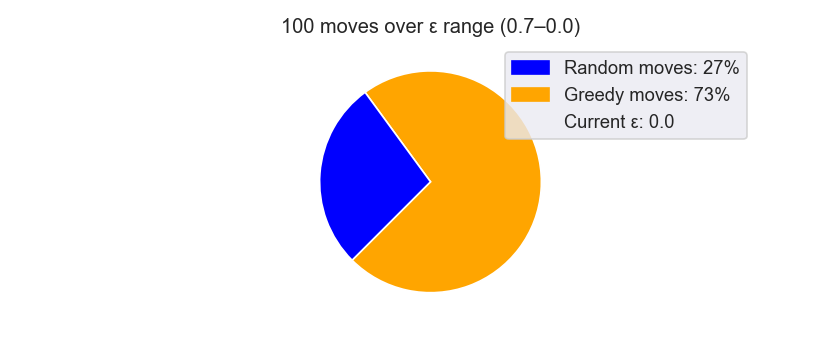

In [30]:
_= affichage.simulate_e_greedy( e_init = .7,
                              e_terminal = 0 )

**Question1** : Expliquer les résultats    
**Réponse1** : Initialement, en fixant un epsilon plus élevé, nous favorisions une exploration plus intensive. Cependant, à mesure que les itérations progressent, l'epsilon diminue, accentuant ainsi l'accent mis sur l'exploitation.     
**Question2** : Pourquoi au debut d'une partie on favorise l'exploitation que l'exploration ?   
**Réponse2** : Dans les premières phases, l'accent est mis sur l'exploration, car l'agent ne possède aucune connaissance préalable de l'environnement. À mesure que l'agent accumule de l'expérience au fil du temps, cette expérience est exploitée pour maximiser les récompenses.

Votre agent utilisera une fonction appelée get_move pour choisir, à chaque étape, soit un mouvement aléatoire, soit un mouvement greedy.

Initialiser un dictionnaire vide appelé `q_table`.

In [31]:
### YOUR CODE HERE ###
q_table = {}
### END OF YOUR CODE ###

In [32]:
q_table

{}

Bien joué !


Maintenant,  vous allez en fait apprendre le *double* Q-Learning. Nous reviendrons bientôt sur la formule epsilon-greedy.


Le **Double Q-Learning** utilise un ensemble parallèle de tables Q pour améliorer les performances en choisissant aléatoirement l'une des deux tables à mettre à jour à chaque étape de la rétropropagation. Pour en savoir plus sur les objectifs et les fondements mathématiques du Double Q-Learning, voir [cet article] (https://towardsdatascience.com/double-q-learning-the-easy-way-a924c4085ec3). Pour l'instant, il est important de savoir que chaque valeur de votre Q Table contiendra en fait **deux dictionnaires imbriqués** de paires `action:récompense` appelés `Q1` et `Q2`. Après l'entraînement, votre `q_table` devrait ressembler à quelque chose comme ceci :

```
q_table = {
         ...
    'OXOXO ' : { Q1 : {5 : 0.32, 6 : 0.23, 7 : 0.35, 8 : 0.65}
                   Q2 : {5 : 0.13, 6 : 0.27, 7 : 0.29, 8 : 0.65} }
    'XOXOXO ' : { Q1 : {6 : 0.27, 7 : 0.49, 8 : 0.16}
                   Q2 : {6 : 0.74, 7 : 0.29, 8 : 0.63} }
         ...
          }
```


Chaque clé de la table Q représente un état du plateau contenant deux dictionnaires imbriqués `Q1` et `Q2`, qui représentent les deux versions de la table Q. Pour chaque état, les deux versions des valeurs Q ont pour clés les coups disponibles et pour valeurs les récompenses associées à chaque coup.  Gardez à l'esprit ce format pour une double table Q dans les sections suivantes. Considérez ce diagramme mis à jour pour récapituler :

![Double Q Learning](dql.png)

Cela signifie que dans votre fonction e-greedy move, pour faire un mouvement "intelligent", prenez la **moyenne** des valeurs Q des deux tables. Rappelez-vous que nous avons défini la table Q comme une variable globale, donc `get_move` interagira avec notre espace de nom global pour déterminer ces valeurs. Maintenant, nous sommes enfin prêts à faire un mouvement.

## 3.2 Fonction ε-Greedy Move

On va créer une fonction appelée `get_move` qui accepte trois arguments par défaut : `b` (le plateau actuel), `epsilon`, et `player` (`X` ou `O`). En utilisant l'algorithme epsilon-greedy ci-dessous, la fonction doit sélectionner et retourner le prochain coup sous la forme d'un index d'une position ouverte sur le plateau. Nous vous présentons ici toutes les étapes de la fonction :

1. On commence par identifier les positions non occupées sur le plateau, en listant tous les coups possibles. 


2. Si le joueur est 'O', On inverse les tuiles sur le plateau en utilisant la fonction `flip_board` que vous avez écrite ci-dessus.


3. Si l'état n'existe pas déjà dans la `q_table`, On initialise avec un dictionnaire imbriqué contenant deux ensembles de paires `action:récompense` nommés `Q1` et `Q2`. Les clés des deux versions de la table doivent être une liste de tous les mouvements possibles à partir de l'état donné. On initialise leurs valeurs à **0.6 ou plus** dans les nouveaux états (qui ne sont pas déjà dans la table Q). Incluez `init_q` comme nouvel argument de mot-clé dans votre fonction `get_move`.


4. On utilise la formule ε-greedy suivante en conjonction avec le module `random` pour choisir une stratégie de déplacement :

\begin{eqnarray*}
&&\mbox{ avec probabilité } \epsilon : \mbox{choisir une action au hasard}\\\
&&\mbox{ avec la probabilité } 1- \epsilon : action = \max_{reward} Q(état, espace d'action)
\end{eqnarray*}

5. Pour un coup "intelligent", On choisit la position avec la récompense moyenne la plus élevée dans **les deux** versions de la table Q. Au début de l'entraînement, cette valeur sera souvent égale ou proche de votre valeur Q initiale.
    - **Défi:** Obtenir les valeurs Q moyennes des deux dictionnaires imbriqués en une ligne de code.


**Completer le code suivant dans les cases appropriées**

In [33]:
def get_move(b, epsilon=.5, player='X', init_q=.3):
    
    global q_table # work with the global Q table
    
    b_key = ''.join(b) # accept b as a string or a list
    
    # reverse tiles if player is O
    if player =='O': b_key = flip_board(b_key)
    
    # list possible moves
    opts = [i for i in range(len(b)) if b[i]==' ']

    # if state is new, initialize in the q_table
    if b_key not in q_table.keys():
        # nested dicts Q1 and Q2 for every board state:
        
        ### YOUR CODE HERE ###
        # HINT : Initaliser la case Q1 et Q2 de l'état b_key pour toutes les actions opts par init_q
        q_table[b_key] = {v: {o:init_q for o in opts} for v in ['Q1', 'Q2']}
        ### END OF YOUR CODE ###
    
    ### YOUR CODE HERE ###
    # HINT : obtenir les valeurs moyennes de Q à partir des deux versions du tableau (Q1, Q2) pour toutes actions opts
    q_vals = {o: sum([q[o] for q in q_table[b_key].values() ])/2 for o in opts}
    ### END OF YOUR CODE ###
     
    # e-greedy decision
    random_move = epsilon > random.uniform(0, 1)
    if random_move: 
        return random.choice(opts) # random move
    else:
        return max(q_vals, key=q_vals.get)  # smart move

In [34]:
get_move(new_board(), epsilon = 0.5)

1

**Question** : Si vous diminuez la valeur d'epsilon dans get_move et que vous l'exécutez plusieurs fois, la position 0 devrait être nettement sur-favorisée. Pourquoi ?  
**Réponse** : 
Quand epsilon est réduit, on privilégie davantage l'exploitation (la sélection de l'action maximisant la valeur actuelle estimée), ce qui pourrait conduire à la répétition systématique du choix de l'action initialement évaluée comme la meilleure (dans ce cas, celle avec une valeur de 0.3).

# 4. Simulations et Backpropagation

## 4.1 Simulateur de match

Pour peupler votre tableau de Q avec de meilleures valeurs, vous aurez besoin d'une fonction pour simuler un match entier. Cette fonction devrait commencer par créer un nouveau tableau, puis itérer entre les joueurs en utilisant `get_move` pour mettre à jour le tableau à chaque étape jusqu'à atteindre une victoire ou une égalité.

Nous allons définir une fonction appelée `simulate_game` qui accepte deux arguments mots-clés, `epsilon_x` et `epsilon_o`. Avec X toujours en premier, on introduit aussi les valeurs **ε** des joueurs respectifs dans la fonction de déplacement pour chaque joueur et continuez à mettre à jour le plateau jusqu'à atteindre un état terminal.

1. On utilise la fonction `evaluator` pour vérifier le plateau au début de chaque itération.
    - Tant que le `résultat` de `evaluator` contient `C`, les joueurs doivent continuer à faire des coups en utilisant leurs valeurs respectives pour epsilon.


2. La rétropropagation exige que nous **souvenions de la séquence des mouvements dans un jeu**, de sorte qu'à la fin nous puissions revenir en arrière et ajuster la valeur Q pour chaque action avec une récompense ou une pénalité en fonction du résultat du match.
   - Avant de démarrer la boucle de jeu, créez une liste vide appelée `steps`.
   - Pour chaque mouvement, ajoutez un dictionnaire de deux éléments à `steps` contenant le `state` du plateau donné (comme une chaîne de 9 caractères) et le prochain `move`.
   
   
3. On va inclur un argument booléen supplémentaire appelé `verb` pour imprimer le résultat et `montrer` l'état final du plateau. 
   
La fonction doit retourner `steps` - une liste de dictionnaires avec l'état actuel et le prochain `move` à chaque étape - et `winner`, un caractère unique représentant le résultat final : `X` ou `O` pour une victoire et `T` pour une égalité.

In [35]:
def simulate_game(epsilon_x=1, epsilon_o=1, verb=False, slow_down=False, size = 3):
    global min_contig
    
    steps = [] # to store the history of states + actions for this game
    
    b=new_board(size)
    while True: # iterate between players with provided e-values attached
        for player, epsilon in zip(['X', 'O'], [epsilon_x, epsilon_o]):
            
            # before each move, check current state
            result = evaluate(b)
                         
            # non-terminal state
            if 'C' in result: 
                
                # use this player's e-value to choose the next move 
                move = get_move(b, epsilon, player)
                
                # store the current board + the chosen action in steps (a history object)
                steps.append({'state':''.join(b.copy()), 'move': move,})
                
                if slow_down: # visualizing in the kernel
                    show(b, helpers=True)
                    print(f'{player} -> {move+1} (ε={epsilon})\n')
                    time.sleep(slow_down*.2)
                    display.clear_output()
                    
                # update the board
                b[move] = player
                
            else: # terminal state
                if verb or slow_down: show(b), print(result)
                return steps, result[0]

In [36]:
steps, winner = simulate_game(slow_down=4)
steps

—————————————
| X || O ||   ||
—————————————
|   || X || O ||
—————————————
|   ||   || X ||
—————————————
X Wins!


[{'state': '         ', 'move': 4},
 {'state': '    X    ', 'move': 5},
 {'state': '    XO   ', 'move': 0},
 {'state': 'X   XO   ', 'move': 1},
 {'state': 'XO  XO   ', 'move': 8}]

Excellent. Notre agent peut maintenant jouer un match complet (bien qu'entièrement aléatoire).

C'est ici qu'intervient la rétropropagation : à l'aide de l'objet steps, vous allez revenir en arrière et mettre à jour la table Q en attribuant des récompenses et des pénalités à des mouvements particuliers. Il s'agit de l'étape finale, et peut-être la plus cruciale, de tout algorithme d'apprentissage par renforcement : grâce à la rétropropagation, l'agent "apprendra" au fil du temps les différents chemins menant au succès ainsi que ceux menant à l'échec.

## 4.2 Mise à jour des valeurs Q

Lorsque vous renvoyez l'algorithme dans la séquence d'étapes d'un match, vous aurez besoin, pour chaque action, d'une fonction permettant d'estimer une nouvelle valeur Q. La formule de mise à jour de Q est la suivante :

\begin{eqnarray*}
Q_\mbox{action} = (1-\mbox{taux d'apprentissage})* Q_\mbox{action} + \mbox{taux d'apprentissage}*(récompense_\mbox{action} + remise * \mbox{max_future_q})\\\
\end{eqnarray*}

En substance, nous ajustons la récompense d'un mouvement à partir d'un état donné en tenant compte à la fois du résultat du jeu (`reward`) **et** du meilleur **meilleur mouvement** possible à partir des états futurs après avoir pris l'action actuelle (`max_future_q`). Le second facteur pose la question suivante : ce coup a-t-il permis de préparer un bon coup futur ? Deux variables globales fixent les limites de l'influence de ces facteurs sur la Table Q :


    
- Taux d'apprentissage - `lrate` - détermine l'agressivité avec laquelle les valeurs de Q doivent être ajustées.   
   
- Discount Factor - `discount` - détermine l'importance des récompenses futures.

**Prompt:** Définissez ces deux variables **globales** comme étant égales à `.15` et `.9` respectivement.

In [37]:
lrate = 0.15
discount = 0.9

Vous alimenterez également la fonction de mise à jour de la valeur Q avec trois variables **locales** (spécifiques à chaque étape) :
    
- `current_q` (float) - Initialisée à 0,6, avec le temps ces valeurs devraient commencer à refléter la qualité des coups.
   
- `reward` (float) - Dépend du nombre de coups restants jusqu'à la fin de la partie (sera déterminé dans la prochaine fonction).
    
- `max_future_q` (float) - La valeur Q du meilleur coup suivant possible selon la table Q actuelle (pas nécessairement un coup effectué dans cette partie).  
   

**Prompt:** En utilisant la formule de mise à jour de la valeur Q ci-dessus, créez une fonction appelée `get_new_q` qui accepte ces trois variables et retourne une nouvelle valeur Q.


In [39]:
def get_new_q(current_q, reward, max_future_q):
    global lrate
    global discount
    
    ### YOUR CODE HERE ###
    return (1-lrate)*current_q + lrate*(reward + discount * max_future_q)
    ### END OF YOUR CODE ###

In [40]:
get_new_q(current_q=.6, reward=.43, max_future_q=.9)

0.696

Bon travail ! Vous avez presque terminé.

Avant de passer à l'étape finale, examinez les résultats de la fonction simulate_game.

Pour la rétropropagation, votre agent doit revenir sur les mouvements effectués par chaque joueur après la fin de la partie. Comment pouvez-vous indexer les états dans les étapes où un seul joueur a effectué ses mouvements ? Considérez comment le résultat d'un jeu affecte le joueur qui a bougé en dernier.

## 4.3 Backpropagation

On va définir une fonction appelée `backpropagate` qui accepte trois arguments : `steps` et `winner` (les sorties de `simulate_game`) et `alpha` (une constante). La fonction doit itérer en arrière à travers les `steps`, en appelant `get_new_q` pour le déplacement effectué à partir de chaque `state`. `backpropagate` va puiser dans votre dictionnaire global `q_table` et y apporter des modifications.

La seule variable que nous devons encore définir est `reward`. En utilisant la formule suivante, nous attribuons des récompenses plus importantes aux mouvements effectués plus tard dans la partie. 


\begin{eqnarray*}
&&\mbox{reward} =  alpha ^\mbox{(n steps remaining)}\\
\end{eqnarray*}


Si le joueur a finalement perdu, rendez la récompense négative pour refléter une pénalité. Dans le cas d'une partie nulle, envisagez de fixer la récompense à une valeur négative mais aussi de réduire son ampleur pour que les pertes difficiles soient moins importantes en comparaison. Toutes les étapes nécessaires pour `backpropagate` sont décrites ci-dessous :


1. Après avoir isolé les étapes faites par un joueur donné, itérer en arrière à travers leurs mouvements. Pour chaque `état` où `O` fait un mouvement, n'oubliez pas d'inverser les tuiles du plateau avant de référencer la `q_table`.


2. Utilisez le module `random` pour choisir soit `Q1` soit `Q2` pour **chaque coup**. Cette table devrait devenir la cible de votre mise à jour sur cet `state`.


3. Rappelez-vous que `max_future_q` est la plus haute valeur Q possible du **prochain état**. Techniquement, cela signifie qu'il faut regarder deux pas en avant, jusqu'à ce que le même joueur ait une autre chance de bouger.
    - Pour le dernier mouvement d'un joueur, définissez manuellement la valeur `max_future_q`. Par exemple, 1 pour une victoire, 0,5 pour une égalité et 0 pour une défaite.
    - Les valeurs `max_future_q` et `current_q` doivent être déterminées en fonction de la version cible de votre `q_table` choisie au hasard à chaque étape.


4. Selon la formule de récompense ci-dessus, vous pouvez trouver utile d'énumérer la liste des états dans lesquels un joueur donné a effectué ses mouvements afin de compter combien d'étapes restent à partir d'un état donné. 

5. Après avoir exécuté `get_new_q`, assurez-vous d'écrire la valeur `new_q` directement dans la version cible (`Q1` ou `Q2`) de votre global `q_table`.

In [41]:
def backpropagate(steps, winner, alpha=.9, wait_seconds=False):
    
    global q_table # make updates to global q table
        
    # backprop for each player
    for player in ['X', 'O']:
        p_steps = steps.copy()
            
    # isolate target player's moves:
        # if O, drop X's first move
        if player=='O':  p_steps = p_steps[1:]
        # board size affects final player in ties!
        if winner == 'T':  # is  number of board tiles odd or even?
            if player =='O' and size**2%2==1: p_steps = p_steps[:-1]
            if player =='X' and size**2%2==0: p_steps = p_steps[:-1]
        # if loser, drop opponent's last move
        elif player!=winner : 
            p_steps = p_steps[:-1] 
        # slice for player steps in reverse
        p_steps = p_steps[::-2]
        
    # iterate backwards over steps (where player moved)
        for n_steps_left, step in enumerate(p_steps):
            # extract state and move from step
            state, move = step['state'], step['move']
             # select random q table version to update
            qv = random.choice(['Q1', 'Q2']) 
            # reverse tiles for O
            if player=='O': state = flip_board(state) 

    # define key variables for get_new_q():
        # define reward
            reward = alpha**(n_steps_left+1)            
            if winner=='T':
                reward *= -.1 # slight penalty for tie
            elif player!=winner:
                reward *= -1 # full penalty for hard loss
            
        # define max_future_q
            # if mid-game move, check future state for player to move:
            if n_steps_left>0: 
                future = p_steps[n_steps_left-1]['state']
                if player=='O': future = flip_board(future)
                max_future_q = max(q_table[future][qv].values())
                
            # if final move, specify max_future_q manually:
            elif player==winner: max_future_q = 1 
            elif winner=='T': max_future_q = .5
            else: max_future_q = 0
            
            current_q = q_table[state][qv][move]

        # UPDATE Q TABLE:
            new_q = get_new_q(current_q, reward, max_future_q)   
            # overwrite target table with new q
            q_table[state][qv][move] = new_q 
                
    return

# 5. Formation et test de l'agent

Vient maintenant la partie la plus gratifiante de l'apprentissage par renforcement : l'entraînement de votre agent sur une série de simulations. Soyez créatif avec votre technique d'entraînement, en vous rappelant que nous avons un contrôle explicite sur les valeurs d'epsilon pour chaque joueur grâce aux arguments des mots-clés que vous avez intégrés dans `simulate_game`.


### 4.1 Entraînement
    
    
On va écrire une fonction appelée `train_agent` qui accepte un argument `iters`, définissant le nombre de parties par session d'entraînement. A la fin de chaque partie, la fonction devrait `backprop` sur le match `steps` et `winner` pour mettre à jour le dictionnaire global `q_table`.

1. Pour encourager l'exploration dans les premières parties de votre simulation, définissez une valeur initiale d'epsilon élevée et diminuez-la au fil du temps.
    - Conseil : ** Étant donné que vous pouvez contrôler la valeur d'epsilon pour chaque joueur, envisagez de vous entraîner dans des lots où un ou les deux joueurs se déplacent de façon complètement aléatoire. Une formation de ce type peut aider votre agent à devenir plus robuste face aux mouvements étranges.


2. **Défi:** Calculez les taux de victoire des joueurs à la fin de chaque partie afin de visualiser le processus d'apprentissage. Pendant ou après la simulation, `train_agent` devrait retourner ces statistiques ou les tracer.


3. N'oubliez pas d'appeler `backprop` à la fin de chaque partie.




In [42]:
def train_agent(iters):
    
    # define game types
    game_types = {
        'Training X (random O)':
            {'random X': False, 'random O': True},
        'Training O (random X)':
            {'random X': True, 'random O': False},
        'Training both (versus)':
            {'random X': False, 'random O': False}     }
    
    # iterate through game types
    for game_type, params in game_types.items():
        # play 1/3  iters per game type
        for i in range(int(iters/3)):
            
            # set player epsilons
            if params['random X']: epsilon_x = 1
            else: epsilon_x = 1-(i/(iters/3)) # *** how we shrink e over one batch *** 
            if params['random O']: epsilon_o = 1
            else: epsilon_o = 1-(i/(iters/3)) # *** how we shrink e over one batch ***
                
            
            # simulate and backpropagate
            steps, winner = simulate_game(epsilon_x, epsilon_o)
            backpropagate(steps, winner)
        
        print(f'{game_type}: | Completed {i+1} simulations.')
    
    print('Training completed.')

**Résultats:**

Il existe de nombreuses façons d'aborder le problème de l'entraînement, c'est pourquoi nous vous fournissons des fonctions ci-dessous pour vous permettre de visualiser deux stratégies possibles. Nos deux fonctions `train_agent` sont enveloppées dans des scripts de traçage, pour représenter les taux de victoire de chaque joueur dans le temps ainsi que les valeurs d'epsilon décroissantes.

La première fonction, `visualize_learning`, anime les taux de victoire des joueurs dans le temps. À droite des graphiques de taux de victoire, nous incluons également des cartes thermiques pour les valeurs Q dans deux tableaux sélectionnés. Ici, vous pouvez voir comment la connaissance de l'agent sur un état particulier se développe au fil du temps.

Launching simulator... done.
Launching animation...

<IPython.core.display.Javascript object>


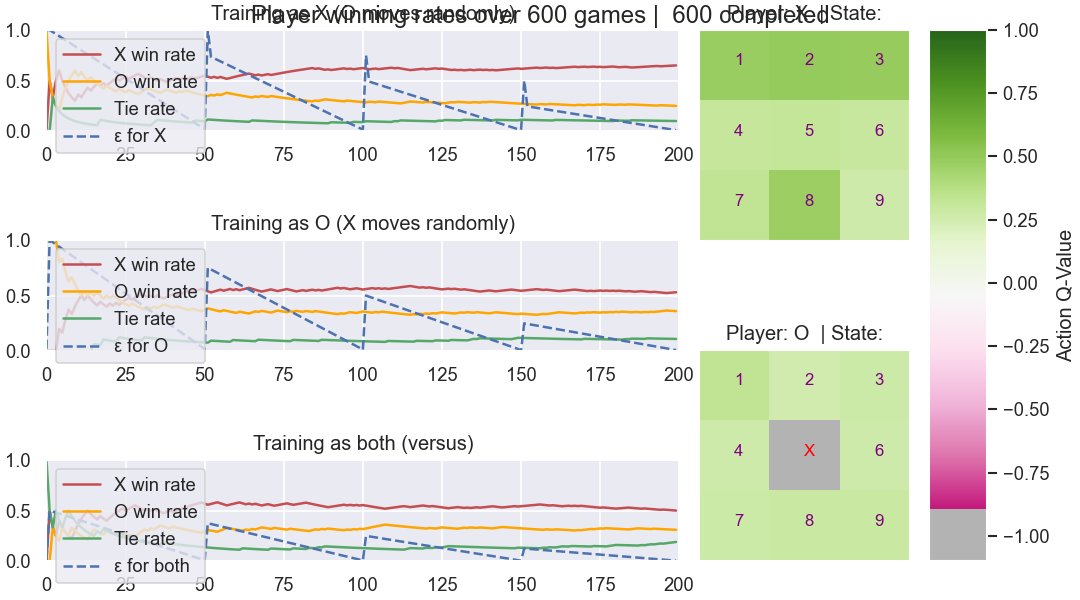

In [43]:
_=affichage.visualize_learning()

**Question** : Que remarquez vous ?   
**Réponse** : 

In [44]:
print(f'The agent has encountered {round(100*len(affichage.q_table)/4520, 2)}% of all possible board states on a 3x3 board')

The agent has encountered 32.06% of all possible board states on a 3x3 board


Pour rapprocher ce chiffre de 100, on effectue beaucoup plus de simulations. Environ 50 000 parties semblent fonctionner.

>>> 45000 games completed in 8.1 s (avg 5556 games/second)
Plotting results:


<IPython.core.display.Javascript object>


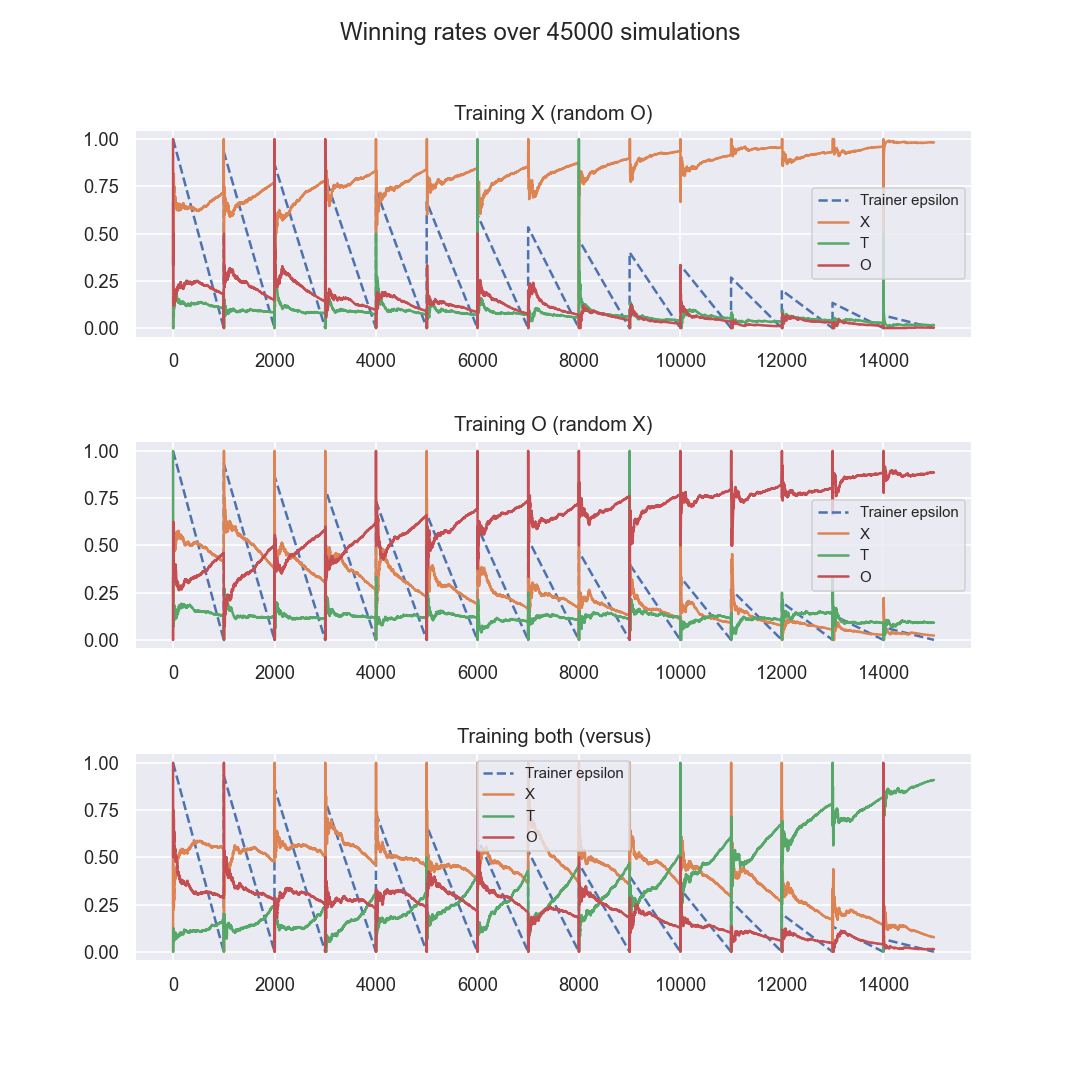

In [45]:
_=affichage.full_training()

In [46]:
print(f'The agent has encountered {round(100*len(affichage.q_table)/4520, 2)}% of all possible board states on a 3x3 board')

The agent has encountered 99.76% of all possible board states on a 3x3 board


## 5.2 Test

Le code suivant est configuré pour que vous puissiez jouer avec l'agent dans un environnement de jeu interactif. Avec votre agent suffisamment entraîné, donnez-lui le meilleur de vous-même.

En jouant le rôle de `X` ou de `O`, pouvez-vous être plus malin que la table Q ?

In [47]:
affichage.versus_agent() # agent from answers module

# Use this to play against the agent you built:
# answers.versus_agent(custom_q_table = q_table) 

Goodbye!


## 6 Deep Q Learning

In [76]:
from itertools import accumulate

m = []
for i in range(len(list(affichage.q_table.keys()))):
    list1 = list(affichage.q_table.values())[i]['Q1'].copy()
    list2 = list(affichage.q_table.values())[i]['Q2'].copy()
    
    
    result = [a + b for a, b in zip(list(list1.values()), (list2.values()))]
    m.append(max(result)/2) 

In [97]:
import pandas as pd
data= {'States': list(affichage.q_table.keys()) , 'Values' : m}
df=pd.DataFrame(data)

In [98]:
df

,States,Values
0,,0.152679
1,O,2.269644
2,O X,1.748709
3,X O O,0.387874
4,OOX X,0.507424
...,...,...
4504,OO XXOX,0.300000
4505,XO O OX X,0.375000
4506,O XO XO,0.366642
4507,X X OOXO,0.300000


C:\Users\T470P\anaconda3\lib\site-packages\matplotlib\animation.py:1688: UserWarning: Can not start iterating the frames for the initial draw. This can be caused by passing in a 0 length sequence for *frames*.

If you passed *frames* as a generator it may be exhausted due to a previous display or save.
  warnings.warn(


In [99]:
df["States"] =  list(map(lambda x: x.replace('X', '0'),  list(df["States"])))
df["States"] =  list(map(lambda x: x.replace('O', '1'),  list(df["States"])))
df["States"] =  list(map(lambda x: x.replace(' ', '2'),  list(df["States"])))

In [100]:
df

,States,Values
0,222222222,0.152679
1,222222221,2.269644
2,222122220,1.748709
3,222021221,0.387874
4,222110220,0.507424
...,...,...
4504,221120010,0.300000
4505,012121020,0.375000
4506,120122012,0.366642
4507,202021101,0.300000


C:\Users\T470P\anaconda3\lib\site-packages\matplotlib\animation.py:1688: UserWarning: Can not start iterating the frames for the initial draw. This can be caused by passing in a 0 length sequence for *frames*.

If you passed *frames* as a generator it may be exhausted due to a previous display or save.
  warnings.warn(


In [101]:
df["nb_vide"] =  list(map(lambda x: x.count('2'),  list(df["States"])))
df["nb_X"] =  list(map(lambda x: x.count('0'),  list(df["States"])))

C:\Users\T470P\anaconda3\lib\site-packages\matplotlib\animation.py:1688: UserWarning: Can not start iterating the frames for the initial draw. This can be caused by passing in a 0 length sequence for *frames*.

If you passed *frames* as a generator it may be exhausted due to a previous display or save.
  warnings.warn(


In [102]:
df

,States,Values,nb_vide,nb_X
0,222222222,0.152679,9,0
1,222222221,2.269644,8,0
2,222122220,1.748709,7,1
3,222021221,0.387874,6,1
4,222110220,0.507424,5,2
...,...,...,...,...
4504,221120010,0.300000,3,3
4505,012121020,0.375000,3,3
4506,120122012,0.366642,4,2
4507,202021101,0.300000,3,3


C:\Users\T470P\anaconda3\lib\site-packages\matplotlib\animation.py:1688: UserWarning: Can not start iterating the frames for the initial draw. This can be caused by passing in a 0 length sequence for *frames*.

If you passed *frames* as a generator it may be exhausted due to a previous display or save.
  warnings.warn(


In [104]:
from keras.models import Sequential
from keras.layers import Dense
from sklearn.model_selection import train_test_split
y=df['Values']
x=df.drop(['Values'], axis=1)
x_train, x_test, y_train, y_test= train_test_split(x,y, train_size=0.7)
model=Sequential([
    Dense(24, activation='sigmoid'),
    Dense(12, activation='sigmoid'),
    Dense(8, activation='sigmoid'),
    Dense(1, activation='relu')
])

model.compile(loss='mean_squared_error', optimizer='adam', metrics=['mse'])
model.fit(x_train, y_train , epochs=20)

Epoch 1/20
99/99 [==============================] - 1s 1ms/step - loss: 0.7369 - mse: 0.7369
Epoch 2/20
99/99 [==============================] - 0s 1ms/step - loss: 0.7369 - mse: 0.7369
Epoch 3/20
99/99 [==============================] - 0s 1ms/step - loss: 0.7369 - mse: 0.7369
Epoch 4/20
99/99 [==============================] - 0s 1ms/step - loss: 0.7369 - mse: 0.7369
Epoch 5/20
99/99 [==============================] - 0s 1ms/step - loss: 0.7369 - mse: 0.7369
Epoch 6/20
99/99 [==============================] - 0s 1ms/step - loss: 0.7369 - mse: 0.7369
Epoch 7/20
99/99 [==============================] - 0s 1ms/step - loss: 0.7369 - mse: 0.7369
Epoch 8/20
99/99 [==============================] - 0s 1ms/step - loss: 0.7369 - mse: 0.7369
Epoch 9/20
99/99 [==============================] - 0s 1ms/step - loss: 0.7369 - mse: 0.7369
Epoch 10/20
99/99 [==============================] - 0s 1ms/step - loss: 0.7369 - mse: 0.7369
Epoch 11/20
99/99 [==============================] - 0s 1ms/step - lo

C:\Users\T470P\anaconda3\lib\site-packages\matplotlib\animation.py:1688: UserWarning: Can not start iterating the frames for the initial draw. This can be caused by passing in a 0 length sequence for *frames*.

If you passed *frames* as a generator it may be exhausted due to a previous display or save.
  warnings.warn(


In [107]:
res = model.evaluate(x_test, y_test)

43/43 [==============================] - 0s 935us/step - loss: 0.7176 - mse: 0.7176


C:\Users\T470P\anaconda3\lib\site-packages\matplotlib\animation.py:1688: UserWarning: Can not start iterating the frames for the initial draw. This can be caused by passing in a 0 length sequence for *frames*.

If you passed *frames* as a generator it may be exhausted due to a previous display or save.
  warnings.warn(


In [108]:
res

[0.7175725698471069, 0.7175725698471069]